<a href="https://colab.research.google.com/github/LeechXDD/9417_Pro_Project/blob/main/COMP9417.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# New Section

In [1]:
!pip install tensorflow_addons
!pip install tensorflow
!pip install tensorflow --upgrade
!pip install --upgrade tensorflow-addons
!pip install keras --upgrade

In [2]:
import tensorflow as tf
import tensorflow_addons as tfa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [3]:
! pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"benedictachun","key":"a3f94529fc258924b3388f08d1efba16"}'}

In [4]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

rm: cannot remove '/root/.kaggle': No such file or directory


In [5]:
!kaggle competitions download -c predict-student-performance-from-game-play
! kaggle datasets list

100% 967M/968M [00:08<00:00, 132MB/s]
100% 968M/968M [00:08<00:00, 126MB/s]
ref                                                            title                                             size  lastUpdated          downloadCount  voteCount  usabilityRating  
-------------------------------------------------------------  -----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
alphiree/cardiovascular-diseases-risk-prediction-dataset       Cardiovascular Diseases Risk Prediction Dataset    5MB  2023-07-03 12:12:19           3945        163  1.0              
nelgiriyewithana/countries-of-the-world-2023                   Global Country Information Dataset 2023           23KB  2023-07-08 20:37:33           2842        105  1.0              
arnavsmayan/netflix-userbase-dataset                           Netflix Userbase Dataset                          25KB  2023-07-04 07:38:41           4009         79  1.0              
iams

In [6]:
! mkdir kaggleData
! unzip predict-student-performance-from-game-play.zip -d kaggleData

from google.colab import drive
drive.mount('/content/drive')

Archive:  predict-student-performance-from-game-play.zip
  inflating: kaggleData/jo_wilder/__init__.py  
  inflating: kaggleData/jo_wilder/competition.cpython-37m-x86_64-linux-gnu.so  
  inflating: kaggleData/jo_wilder_310/__init__.py  
  inflating: kaggleData/jo_wilder_310/competition.cpython-310-x86_64-linux-gnu.so  
  inflating: kaggleData/sample_submission.csv  
  inflating: kaggleData/test.csv     
  inflating: kaggleData/train.csv    
  inflating: kaggleData/train_labels.csv  
Mounted at /content/drive


In [7]:
def get_minimal_dtype(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype.name
        if ((col_type != 'datetime64[ns]') & (col_type != 'category')):
            if (col_type != 'object'):
                c_min = df[col].min()
                c_max = df[col].max()

                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)

                else:
                    if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                        df[col] = df[col].astype(np.float16)
                    elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        pass
            else:
                df[col] = df[col].astype('category')
    mem_usg = df.memory_usage().sum() / 1024**2
    print("Memory usage became: ",mem_usg," MB")

    return df

In [8]:
train_data = pd.read_csv('kaggleData/train.csv')

In [9]:
train_data = get_minimal_dtype(train_data)
test_data = pd.read_csv('kaggleData/test.csv')

Memory usage of dataframe is 4012.60 MB
Memory usage became:  1028.2593326568604  MB


In [10]:
# Load in labels for training dataset
labels = pd.read_csv('kaggleData/train_labels.csv')
labels['session'] = labels.session_id.apply(lambda x: int(x.split('_')[0]) )
labels['q'] = labels.session_id.apply(lambda x: int(x.split('_')[-1][1:]) )

#### Data Cleaning
The columns with missing values are:

- page: This is only for notebook-related events. The missing values could indicate that the event is not related to the notebook. We could fill missing values with a placeholder like -1 to denote 'Not Applicable'.
- room_coor_x, room_coor_y, screen_coor_x, screen_coor_y: These are the coordinates of the click, and are only relevant for click events. Similar to 'page', we could fill missing values with a placeholder.
- hover_duration: This is only for hover events. We can use the same approach as for the coordinates.
- text, fqid, text_fqid: These columns contain information about the event and the room. Missing values could indicate that the event does not involve any text or specific interactions that would be recorded in these fields. We could replace missing values with a placeholder like 'None' or 'Not Applicable'.

In [13]:
# Find out columns with missing values
missing_values = train_data.isnull().sum()

# Fill missing values
train_data['page'].fillna(-1, inplace=True)
train_data['room_coor_x'].fillna(-1, inplace=True)
train_data['room_coor_y'].fillna(-1, inplace=True)
train_data['screen_coor_x'].fillna(-1, inplace=True)
train_data['screen_coor_y'].fillna(-1, inplace=True)
train_data['hover_duration'].fillna(-1, inplace=True)

### Exploratory Data Analysis

In [14]:
# Set plot style
sns.set_style("whitegrid")

# Create a function for easy plotting
def plot_count(train_data, column, title, color, rotation=0):
    plt.figure(figsize=(12,6))
    sns.countplot(data=train_data, x=column, order=train_data[column].value_counts().index, color=color)
    plt.title(title, size=16)
    plt.xticks(rotation=rotation)
    plt.show()

#### Distribution of the Event Names
The most common event in the dataset is 'navigate_click', followed by 'notification_click'. These events likely relate to key interactions within the game and could be influential in a model's ability to predict student performance.

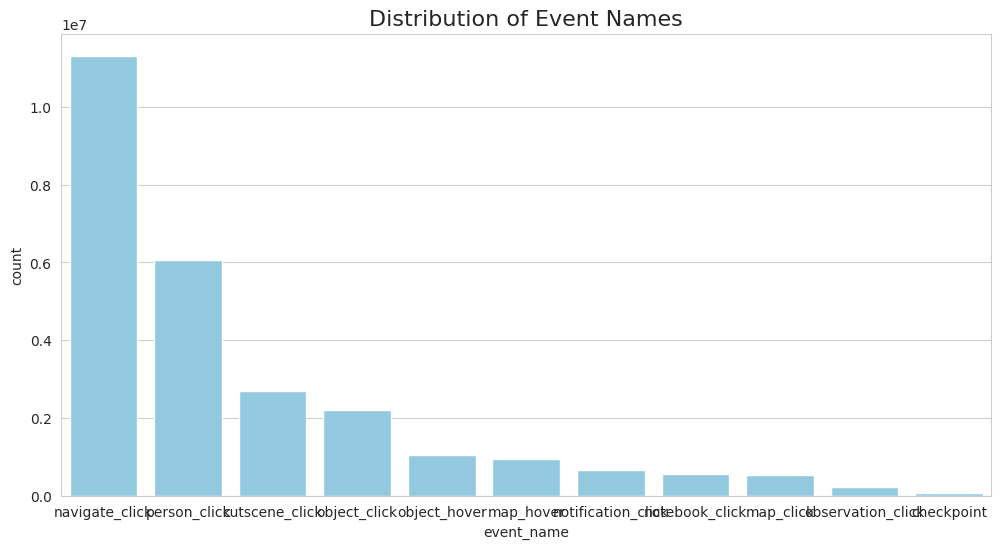

In [15]:
# Plot the distribution of event names
plot_count(train_data, 'event_name', 'Distribution of Event Names', 'skyblue')

#### Distribution of Game Levels
The distribution of game levels shows that the majority of the events are happening in the middle levels of the game (around level 10). This could suggest that most users progress to these levels before stopping, or that these levels simply have more interactive events.

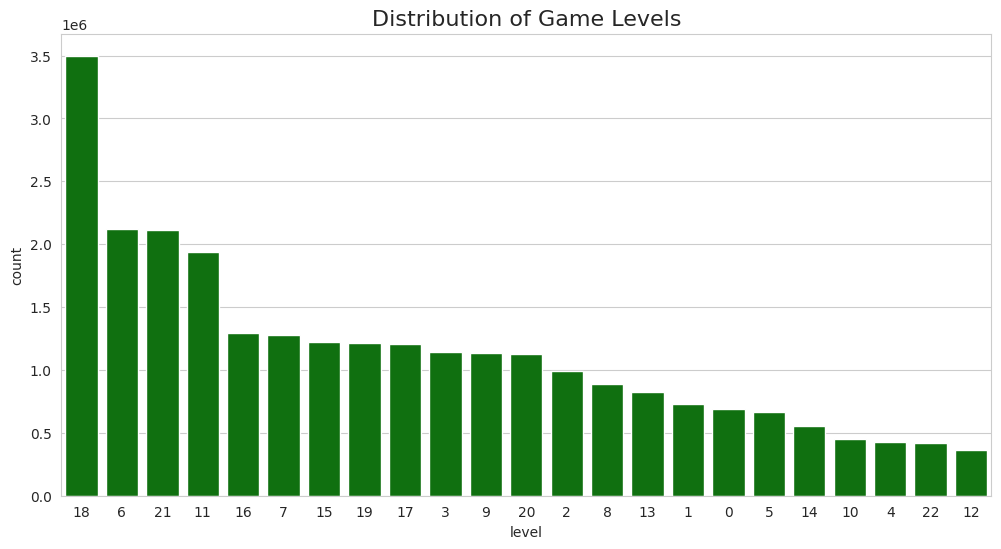

In [16]:
# Plot the distribution of levels
plot_count(train_data, 'level', 'Distribution of Game Levels', 'green')

#### Distribution of Level Groups
The level group distribution shows that the majority of events belong to the '5-12' level group. This is consistent with the distribution of game levels, as the majority of events occurred at these levels.

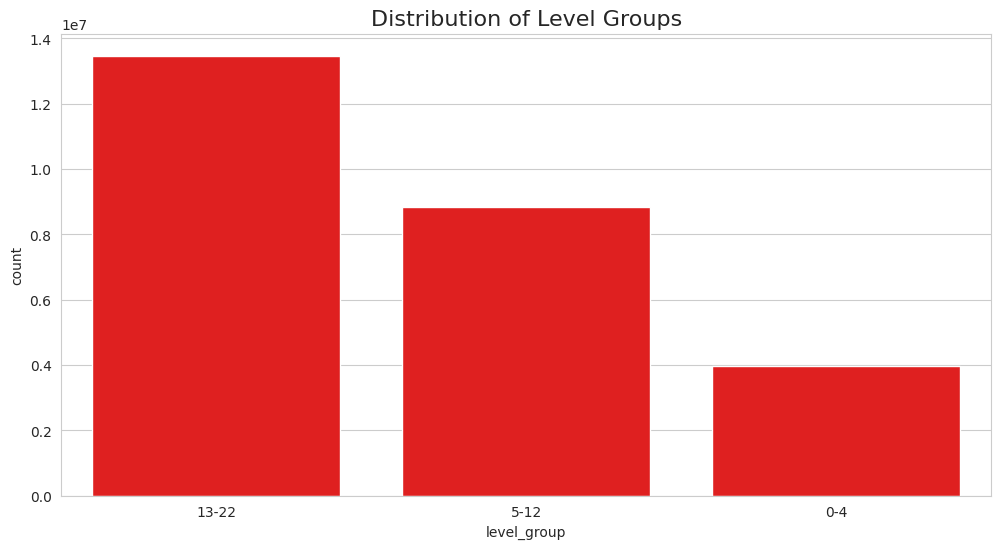

In [17]:
# Plot the distribution of level groups
plot_count(train_data, 'level_group', 'Distribution of Level Groups', 'red')

#### Elapsed Time Statistics
From the histogram of 'elapsed_time', we can observe that the distribution is heavily skewed to the right, with a few sessions having unusually high elapsed time values. These could potentially be outliers or errors in the data.

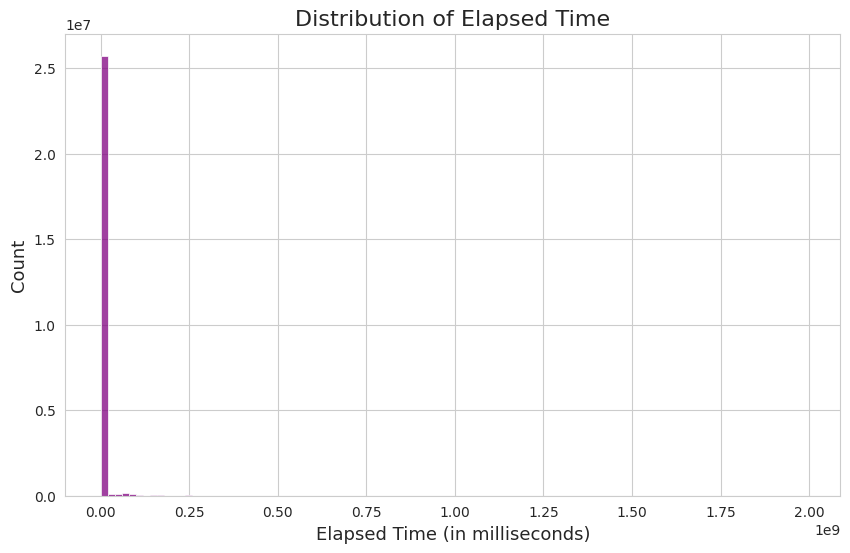

In [18]:
# Display statistics related to elapsed time
elapsed_time_stats = train_data['elapsed_time'].describe()
elapsed_time_stats

# Plot the distribution of 'elapsed_time'
plt.figure(figsize=(10, 6))
sns.histplot(train_data['elapsed_time'], bins=100, color='purple')
plt.title('Distribution of Elapsed Time', size=16)
plt.xlabel('Elapsed Time (in milliseconds)', size=13)
plt.ylabel('Count', size=13)
plt.show()

From the table below it shows subset of the data that falls in the top 1% of 'elapsed_time' which could suggest outliers.

In [19]:
# Check the values on the high end of 'elapsed_time'
high_elapsed_time = train_data[train_data['elapsed_time'] > train_data['elapsed_time'].quantile(0.99)]
high_elapsed_time

,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
62160,20100012562027690,412,122550441,object_hover,undefined,9,-1.0,-1.00000,-1.000000,-1.0,-1.0,31.0,NaN,reader.paper2.next,tunic.library.microfiche,NaN,0,0,1,5-12
62161,20100012562027690,413,122551391,object_click,basic,9,-1.0,25.84375,-218.000000,473.0,548.0,-1.0,NaN,reader.paper2.next,tunic.library.microfiche,NaN,0,0,1,5-12
62162,20100012562027690,414,122553183,object_hover,undefined,9,-1.0,-1.00000,-1.000000,-1.0,-1.0,1785.0,NaN,reader.paper2.next,tunic.library.microfiche,NaN,0,0,1,5-12
62163,20100012562027690,415,122553580,object_hover,undefined,9,-1.0,-1.00000,-1.000000,-1.0,-1.0,734.0,NaN,reader.paper0.prev,tunic.library.microfiche,NaN,0,0,1,5-12
62164,20100012562027690,416,122558505,object_hover,undefined,9,-1.0,-1.00000,-1.000000,-1.0,-1.0,84.0,NaN,reader.paper0.prev,tunic.library.microfiche,NaN,0,0,1,5-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26288096,22100215032067016,984,85742264,map_hover,basic,22,-1.0,-1.00000,-1.000000,-1.0,-1.0,66.0,NaN,tunic.capitol_2,tunic.historicalsociety.entry,NaN,0,0,1,13-22
26288097,22100215032067016,985,85742848,map_hover,basic,22,-1.0,-1.00000,-1.000000,-1.0,-1.0,168.0,NaN,tunic.historicalsociety,tunic.historicalsociety.entry,NaN,0,0,1,13-22
26288098,22100215032067016,986,85743265,map_click,undefined,22,-1.0,511.75000,59.500000,474.0,293.0,-1.0,NaN,tunic.capitol_2,tunic.historicalsociety.entry,NaN,0,0,1,13-22
26288099,22100215032067016,987,85744579,navigate_click,undefined,22,-1.0,262.00000,4.882812,429.0,294.0,-1.0,NaN,chap4_finale_c,tunic.capitol_2.hall,NaN,0,0,1,13-22


So I will set all 'elapsed_time' values above the 99th percentile to the 99th percentile value. This would limit the effect of extreme values without completely removing them from the dataset.

In [20]:
# Cap 'elapsed_time' at the 99th percentile
train_data['elapsed_time'] = train_data['elapsed_time'].clip(upper=train_data['elapsed_time'].quantile(0.99))

The maximum value is now significantly lower than before, while the other statistics (mean, standard deviation, etc.) remain similar. This means that the extreme high values have been limited, which should help to reduce their influence on the model.

In [21]:
# Verify the change
train_data['elapsed_time'].describe()

count    2.629695e+07
mean     2.734765e+06
std      9.689942e+06
min      0.000000e+00
25%      4.397000e+05
50%      1.014801e+06
75%      1.747040e+06
max      7.756060e+07
Name: elapsed_time, dtype: float64

### Feature Engineering

In [22]:
CATEGORICAL = ['event_name', 'name','fqid', 'room_fqid', 'text_fqid']
NUMERICAL = ['elapsed_time','level','page','room_coor_x', 'room_coor_y',
        'screen_coor_x', 'screen_coor_y', 'hover_duration']

def feature_engineer(dataset_df):
    dfs = []
    for c in CATEGORICAL:
        tmp = dataset_df.groupby(['session_id','level_group'])[c].agg('nunique')
        tmp.name = tmp.name + '_nunique'
        dfs.append(tmp)
    for c in NUMERICAL:
        tmp = dataset_df.groupby(['session_id','level_group'])[c].agg('mean')
        dfs.append(tmp)
    for c in NUMERICAL:
        tmp = dataset_df.groupby(['session_id','level_group'])[c].agg('std')
        tmp.name = tmp.name + '_std'
        dfs.append(tmp)
    dataset_df = pd.concat(dfs,axis=1)
    dataset_df = dataset_df.fillna(-1)
    dataset_df = dataset_df.reset_index()
    dataset_df = dataset_df.set_index('session_id')
    return dataset_df



### Improved version of feature engineering function

In [ ]:
CATEGORICAL = ['event_name', 'name','fqid', 'room_fqid', 'text_fqid']
NUMERICAL = ['elapsed_time','level','page','room_coor_x', 'room_coor_y',
        'screen_coor_x', 'screen_coor_y', 'hover_duration']

# Define feature engineering function
def feature_engineer_ver2(dataset_df):
    dfs = []
    for c in CATEGORICAL:
        tmp = dataset_df.groupby(['session_id','level_group'])[c].agg('nunique')
        tmp.name = c + '_nunique'
        dfs.append(tmp)

    for c in NUMERICAL:
        tmp = dataset_df.groupby(['session_id','level_group'])[c].agg('mean')
        tmp.name = c + '_mean'
        dfs.append(tmp)

        tmp = dataset_df.groupby(['session_id','level_group'])[c].agg('std')
        tmp.name = c + '_std'
        dfs.append(tmp)

        # Binning
        if dataset_df[c].nunique() > 1:  # Check if column has more than one unique value
            dataset_df[c+'_bin'] = pd.qcut(dataset_df[c], q=4, duplicates='drop')
            tmp = dataset_df.groupby(['session_id','level_group'])[c+'_bin'].agg('count')
            tmp.name = c + '_bin_count'
            dfs.append(tmp)

    # Interaction between screen coordinates
    if 'screen_coor_x' in NUMERICAL and 'screen_coor_y' in NUMERICAL:
        dataset_df['screen_coor'] = dataset_df['screen_coor_x'] * dataset_df['screen_coor_y']
        tmp = dataset_df.groupby(['session_id','level_group'])['screen_coor'].agg(['mean', 'std'])
        tmp.columns = ['screen_coor_mean', 'screen_coor_std']
        dfs.append(tmp)

    # Aggregated features
    if 'hover_duration' in NUMERICAL:
        dataset_df['total_hover_duration'] = dataset_df.groupby(['session_id'])['hover_duration'].transform('sum')
        tmp = dataset_df.groupby(['session_id','level_group'])['total_hover_duration'].agg('mean')
        tmp.name = 'total_hover_duration_mean'
        dfs.append(tmp)

    dataset_df = pd.concat(dfs,axis=1)
    dataset_df = dataset_df.fillna(-1)
    dataset_df = dataset_df.reset_index()
    dataset_df = dataset_df.set_index('session_id')
    return dataset_df


In [29]:
CATEGORICAL = ['event_name', 'name','fqid', 'room_fqid', 'text_fqid']
NUMERICAL = ['elapsed_time','level','page','room_coor_x', 'room_coor_y',
        'screen_coor_x', 'screen_coor_y', 'hover_duration']
BINNING = ['elapsed_time', 'room_coor_x', 'room_coor_y', 'screen_coor_x', 'screen_coor_y', 'hover_duration']

# Define feature engineering function
def feature_engineer_ver3(dataset_df):
    dfs = []
    for c in CATEGORICAL:
        tmp = dataset_df.groupby(['session_id','level_group'])[c].agg('nunique')
        tmp.name = c + '_nunique'
        dfs.append(tmp)

    for c in NUMERICAL:
        tmp = dataset_df.groupby(['session_id','level_group'])[c].agg('mean')
        tmp.name = c + '_mean'
        dfs.append(tmp)

        # Compute standard deviation only for certain features
        if c in BINNING:
            tmp = dataset_df.groupby(['session_id','level_group'])[c].agg('std')
            tmp.name = c + '_std'
            dfs.append(tmp)

        # Binning
        if c in BINNING:  # Check if column is in the list of columns to bin
            dataset_df[c+'_bin'] = pd.qcut(dataset_df[c], q=4, duplicates='drop')
            tmp = dataset_df.groupby(['session_id','level_group'])[c+'_bin'].agg('count')
            tmp.name = c + '_bin_count'
            dfs.append(tmp)

    # Interaction between screen coordinates
    if 'screen_coor_x' in NUMERICAL and 'screen_coor_y' in NUMERICAL:
        # Compute Euclidean distance instead of product
        dataset_df['screen_coor'] = np.sqrt(dataset_df['screen_coor_x']**2 + dataset_df['screen_coor_y']**2)
        tmp = dataset_df.groupby(['session_id','level_group'])['screen_coor'].agg(['mean', 'std'])
        tmp.columns = ['screen_coor_mean', 'screen_coor_std']
        dfs.append(tmp)

    # Aggregated features
    if 'hover_duration' in NUMERICAL:
        dataset_df['total_hover_duration'] = dataset_df.groupby(['session_id'])['hover_duration'].transform('sum')
        tmp = dataset_df.groupby(['session_id','level_group'])['total_hover_duration'].agg('mean')
        tmp.name = 'total_hover_duration_mean'
        dfs.append(tmp)

    dataset_df = pd.concat(dfs,axis=1)
    dataset_df = dataset_df.fillna(-1)
    dataset_df = dataset_df.reset_index()
    dataset_df = dataset_df.set_index('session_id')
    return dataset_df


In [44]:

def feature_engineer_ver4(dataset_df):
    # First fill missing values for numeric columns
    dataset_df.fillna({"room_coor_x": dataset_df["room_coor_x"].mean(),
                       "room_coor_y": dataset_df["room_coor_y"].mean(),
                       "screen_coor_x": dataset_df["screen_coor_x"].mean(),
                       "screen_coor_y": dataset_df["screen_coor_y"].mean(),
                       "hover_duration": dataset_df["hover_duration"].mean(),
                       "page": -1}, inplace=True)

    # Fill missing values for categorical columns with the most frequent category
    for c in CATEGORICAL:
        most_frequent_category = dataset_df[c].mode()[0]
        dataset_df[c].fillna(most_frequent_category, inplace=True)

    dfs = []
    for c in CATEGORICAL:
        tmp = dataset_df.groupby(['session_id','level_group'])[c].agg('nunique')
        tmp.name = c + '_nunique'
        dfs.append(tmp)

    for c in NUMERICAL:
        tmp = dataset_df.groupby(['session_id','level_group'])[c].agg('mean')
        tmp.name = c + '_mean'
        dfs.append(tmp)

        tmp = dataset_df.groupby(['session_id','level_group'])[c].agg('std')
        tmp.name = c + '_std'
        dfs.append(tmp)

        # Binning
        if dataset_df[c].nunique() > 1:  # Check if column has more than one unique value
            dataset_df[c+'_bin'] = pd.qcut(dataset_df[c], q=4, duplicates='drop')
            tmp = dataset_df.groupby(['session_id','level_group'])[c+'_bin'].agg('count')
            tmp.name = c + '_bin_count'
            dfs.append(tmp)

    # Interaction between screen coordinates
    if 'screen_coor_x' in NUMERICAL and 'screen_coor_y' in NUMERICAL:
        dataset_df['screen_coor'] = dataset_df['screen_coor_x'] * dataset_df['screen_coor_y']
        tmp = dataset_df.groupby(['session_id','level_group'])['screen_coor'].agg(['mean', 'std'])
        tmp.columns = ['screen_coor_mean', 'screen_coor_std']
        dfs.append(tmp)

    # Aggregated features
    if 'hover_duration' in NUMERICAL:
        dataset_df['total_hover_duration'] = dataset_df.groupby(['session_id'])['hover_duration'].transform('sum')
        tmp = dataset_df.groupby(['session_id','level_group'])['total_hover_duration'].agg('mean')
        tmp.name = 'total_hover_duration_mean'
        dfs.append(tmp)

    dataset_df = pd.concat(dfs,axis=1)
    dataset_df = dataset_df.reset_index()
    dataset_df = dataset_df.set_index('session_id')

    return dataset_df


In [ ]:
# Define feature engineering function
def feature_engineer_ver5(dataset_df):
    # Filling missing values
    # For numerical features use median
    for c in NUMERICAL:
        dataset_df[c].fillna(dataset_df[c].median(), inplace=True)

    # For categorical features use mode
    for c in CATEGORICAL:
        dataset_df[c].fillna(dataset_df[c].mode()[0], inplace=True)

    # Continue with your feature engineering as before
    dfs = []
    for c in CATEGORICAL:
        tmp = dataset_df.groupby(['session_id','level_group'])[c].agg('nunique')
        tmp.name = c + '_nunique'
        dfs.append(tmp)

    for c in NUMERICAL:
        tmp = dataset_df.groupby(['session_id','level_group'])[c].agg('mean')
        tmp.name = c + '_mean'
        dfs.append(tmp)

        tmp = dataset_df.groupby(['session_id','level_group'])[c].agg('std')
        tmp.name = c + '_std'
        dfs.append(tmp)

        # Binning
        if dataset_df[c].nunique() > 1:  # Check if column has more than one unique value
            dataset_df[c+'_bin'] = pd.qcut(dataset_df[c], q=4, duplicates='drop')
            tmp = dataset_df.groupby(['session_id','level_group'])[c+'_bin'].agg('count')
            tmp.name = c + '_bin_count'
            dfs.append(tmp)

    # Interaction between screen coordinates
    if 'screen_coor_x' in NUMERICAL and 'screen_coor_y' in NUMERICAL:
        dataset_df['screen_coor'] = dataset_df['screen_coor_x'] * dataset_df['screen_coor_y']
        tmp = dataset_df.groupby(['session_id','level_group'])['screen_coor'].agg(['mean', 'std'])
        tmp.columns = ['screen_coor_mean', 'screen_coor_std']
        dfs.append(tmp)

    # Aggregated features
    if 'hover_duration' in NUMERICAL:
        dataset_df['total_hover_duration'] = dataset_df.groupby(['session_id'])['hover_duration'].transform('sum')
        tmp = dataset_df.groupby(['session_id','level_group'])['total_hover_duration'].agg('mean')
        tmp.name = 'total_hover_duration_mean'
        dfs.append(tmp)

    dataset_df = pd.concat(dfs,axis=1)
    dataset_df = dataset_df.reset_index()
    dataset_df = dataset_df.set_index('session_id')

    return dataset_df


### Test run on sample of dataset *****************

In [45]:
sample = train_data.sample(frac=0.05)
#dataset_df = feature_engineer(sample)
#dataset_df = feature_engineer_ver2(sample)
#dataset_df = feature_engineer_ver3(sample)
dataset_df = feature_engineer_ver4(sample)
dataset_df.head()

,level_group,event_name_nunique,name_nunique,fqid_nunique,room_fqid_nunique,text_fqid_nunique,elapsed_time_mean,elapsed_time_std,elapsed_time_bin_count,level_mean,...,screen_coor_x_bin_count,screen_coor_y_mean,screen_coor_y_std,screen_coor_y_bin_count,hover_duration_mean,hover_duration_std,hover_duration_bin_count,screen_coor_mean,screen_coor_std,total_hover_duration_mean
session_id,,,,,,,,,,,,,,,,,,,,,
20090312431273200,0-4,3,2,6,4,1,1.028412e+05,45782.908573,9,2.444444,...,9,291.444458,158.059412,9,704.666687,2117.000000,9,NaN,NaN,7103.0
20090312431273200,13-22,3,2,8,6,5,1.059049e+06,80802.109618,14,17.928571,...,14,368.714294,121.857059,14,55.071430,209.800075,14,NaN,NaN,7103.0
20090312431273200,5-12,4,2,4,7,4,3.695547e+05,69333.110766,10,8.200000,...,10,343.700012,88.878256,10,-1.000000,0.000000,10,NaN,NaN,7103.0
20090312433251036,0-4,3,2,4,4,4,1.051730e+05,68347.117886,7,1.857143,...,7,401.857147,93.906742,7,-1.000000,0.000000,7,NaN,NaN,7771.0
20090312433251036,13-22,9,3,26,14,8,2.400658e+06,732070.193504,65,17.707692,...,65,328.246155,206.567107,65,101.415382,306.196367,65,NaN,NaN,7771.0


In [46]:
# Replace `inf` values:
dataset_df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Replace `NaN` values with column mean:
dataset_df.fillna(dataset_df.mean(), inplace=True)


<ipython-input-46-0ee892e4a869>:5: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  dataset_df.fillna(dataset_df.mean(), inplace=True)


### XGB Code

In [47]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import KFold,GroupKFold
from sklearn.metrics import f1_score

In [48]:
# Define GroupKFold with 10 splits
#gkf = GroupKFold(n_splits=10)
gkf = GroupKFold(n_splits=5)

# Select features for the model
features = [c for c in dataset_df.columns if c != 'level_group']

# Get unique session IDs as validation data
valid = dataset_df.index.unique()

# Dictionary to store trained models
models = {}

# DataFrame to store model predictions
out_prediction = pd.DataFrame(data = np.zeros((len(valid), 18)), index = valid)


# Perform cross-validation with GroupKFold

for i, (train_index, test_index) in enumerate(gkf.split(X = dataset_df, groups = dataset_df.index)):
    print(); print()
    print('#' * 40)
    print('#' * 5, ' ' * 10, f'Fold {i+1}', ' ' * 10, '#' * 5)
    print('#' * 40)

    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'learning_rate': 0.01,
        'max_depth': 4,
        'n_estimators': 1000,
        'early_stopping_rounds': 50,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
    }

    # Iterate through questions 1 to 18
    for t in range(1, 19):

        # Determine the level group for the current question
        if t >= 0 and t <= 3:
            year_group = '0-4'
        elif t >= 4 and t <= 13:
            year_group = '5-12'
        elif t >= 14 and t <= 22:
            year_group = '13-22'

        # Get the train and validation data for the current question and level group
        x_train = dataset_df.iloc[train_index]
        x_train = x_train.loc[x_train.level_group == year_group]
        train_users = x_train.index.values
        y_train = labels.loc[labels.q == t].set_index('session').loc[train_users]

        x_valid = dataset_df.iloc[test_index]
        x_valid = x_valid.loc[x_valid.level_group == year_group]
        valid_users = x_valid.index.values
        y_valid = labels.loc[labels.q == t].set_index('session').loc[valid_users]

        # Train an XGBoost model for the current question and level group
        model = XGBClassifier(**params)
        model.fit(
            x_train[features].astype('float32'), y_train['correct'],
            eval_set=[(x_valid[features].astype('float32'), y_valid['correct'])],
            verbose=0
        )

        # print out the output
        print(f'Q:{t} (year group: {year_group})(best_num_trees: {model.best_ntree_limit})', end='\n')

        # Store the trained model
        models[f'{year_group}_{t}'] = model

        out_prediction.loc[valid_users, t-1] = model.predict_proba(x_valid[features].astype('float32'))[:, 1]



########################################
#####            Fold 1            #####
########################################
Q:1 (year group: 0-4)(best_num_trees: 421)
Q:2 (year group: 0-4)(best_num_trees: 491)
Q:3 (year group: 0-4)(best_num_trees: 522)
Q:4 (year group: 5-12)(best_num_trees: 431)
Q:5 (year group: 5-12)(best_num_trees: 285)
Q:6 (year group: 5-12)(best_num_trees: 469)
Q:7 (year group: 5-12)(best_num_trees: 359)
Q:8 (year group: 5-12)(best_num_trees: 442)
Q:9 (year group: 5-12)(best_num_trees: 635)
Q:10 (year group: 5-12)(best_num_trees: 396)
Q:11 (year group: 5-12)(best_num_trees: 257)
Q:12 (year group: 5-12)(best_num_trees: 395)
Q:13 (year group: 5-12)(best_num_trees: 482)
Q:14 (year group: 13-22)(best_num_trees: 651)
Q:15 (year group: 13-22)(best_num_trees: 398)
Q:16 (year group: 13-22)(best_num_trees: 373)
Q:17 (year group: 13-22)(best_num_trees: 237)
Q:18 (year group: 13-22)(best_num_trees: 455)


########################################
#####            Fold 2      

KeyboardInterrupt: ignored

In [34]:
# Create a copy of the out_prediction DataFrame
true_table = out_prediction.copy()

# Iterate through the questions (indices 0 to 17)
for i in range(18):
    # Filter the labels DataFrame for the current question and select the corresponding sessions in the validation set
    tmp = labels.loc[labels.q == i + 1].set_index('session').loc[valid]

    # Update the i-th column of the true_table DataFrame with the 'correct' values from tmp
    true_table[i] = tmp.correct.values

In [35]:
scores = []; thresholds = []
best_score = 0; best_threshold = 0

# Iterate through a range of thresholds from 0.4 to 0.8 with a step size of 0.01
for threshold in np.arange(0.4, 0.81, 0.01):
    print(f'threshold: {threshold:.02f}, ', end='')

    # Convert the predicted probabilities in out_prediction to binary predictions using the current threshold
    preds = (out_prediction.values.reshape((-1)) > threshold).astype('int')

    # Calculate the macro-average F1 score between the true_table and the binary predictions
    m = f1_score(true_table.values.reshape((-1)), preds, average='macro')

    # Append the F1 score and threshold to the scores and thresholds lists, respectively
    scores.append(m)
    thresholds.append(threshold)

    # Check if the current F1 score is better than the previous best score
    if m > best_score:
        best_score = m
        best_threshold = threshold

threshold: 0.40, threshold: 0.41, threshold: 0.42, threshold: 0.43, threshold: 0.44, threshold: 0.45, threshold: 0.46, threshold: 0.47, threshold: 0.48, threshold: 0.49, threshold: 0.50, threshold: 0.51, threshold: 0.52, threshold: 0.53, threshold: 0.54, threshold: 0.55, threshold: 0.56, threshold: 0.57, threshold: 0.58, threshold: 0.59, threshold: 0.60, threshold: 0.61, threshold: 0.62, threshold: 0.63, threshold: 0.64, threshold: 0.65, threshold: 0.66, threshold: 0.67, threshold: 0.68, threshold: 0.69, threshold: 0.70, threshold: 0.71, threshold: 0.72, threshold: 0.73, threshold: 0.74, threshold: 0.75, threshold: 0.76, threshold: 0.77, threshold: 0.78, threshold: 0.79, threshold: 0.80, 

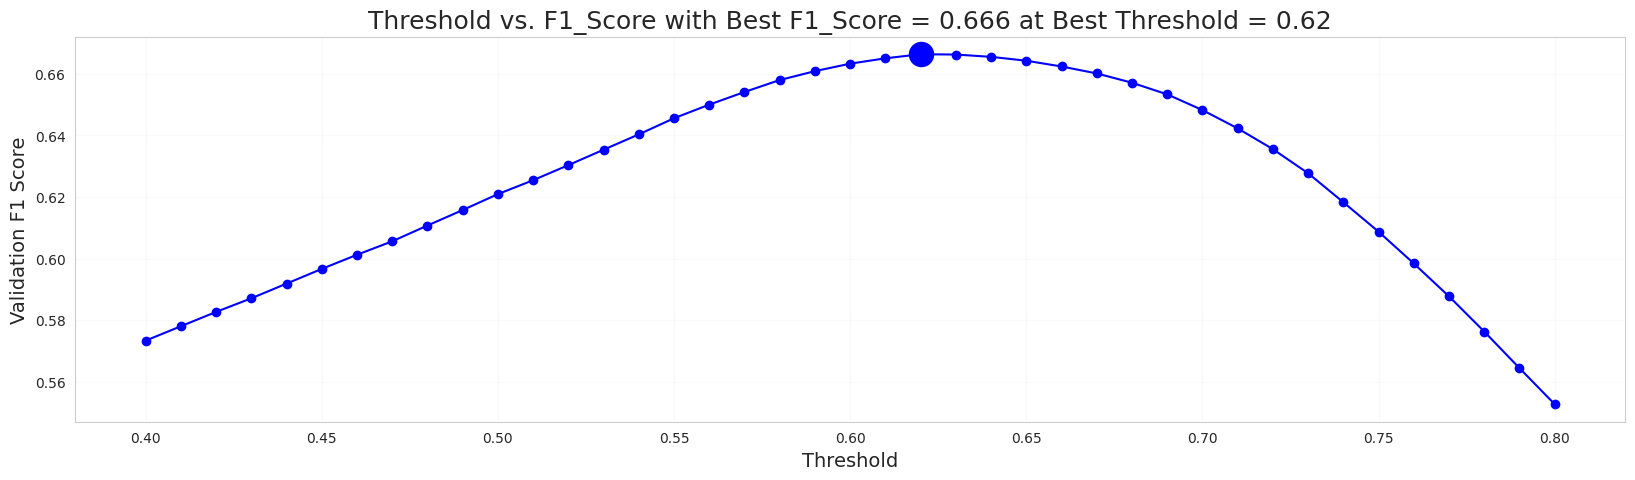

In [36]:
#0.663, 0.63 (feature_engineer)

# PLOT THRESHOLD VS. F1_SCORE
plt.figure(figsize = (20, 5))
plt.plot(thresholds, scores, '-o', color = 'blue')
plt.scatter([best_threshold], [best_score], color = 'blue', s = 300, alpha = 1)
plt.xlabel('Threshold', size = 14)
plt.ylabel('Validation F1 Score', size = 14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score = {best_score:.3f} at Best Threshold = {best_threshold:.3}', size=18)
plt.grid(alpha=0.1)
plt.show()